--------------
# Playbook 6c : Capsule Network Tuning
--------------
Train capsule network on the image data set and determine what works as a good
set of kernel sizes and filters for color images. Stride value in the primary
capsule was set to 1 for this testing.

## 1. Bring zipped data file across from gdrive to extract locally within colab

In [0]:
# Like a great many other libraries in Python, Keras is a mess of incompatability. 
# Need to use 2.2.4 or it breaks the CapsNet Code. I therefore standardise on 
# keras and tensorflow versions
!pip install gast==0.3.2
!pip install keras==2.2.4
!pip install tensorflow==1.15.2

In [2]:
%env GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode

from google.colab import drive
drive.mount('/content/gdrive')
!cp "$GPATH/Datasets/processed-cell-images-malaria.zip" "processed-cell-images-malaria.zip"

env: GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## 2. Remove existing dataset and extract dataset zip file

In [3]:
!rm -rf cell_images
!rm -rf dataset
!unzip -q 'processed-cell-images-malaria.zip'
!ls

dataset  gdrive  processed-cell-images-malaria.zip  sample_data


## 3. Import required packages

In [4]:
%tensorflow_version 1.15 

import os
import shutil
import numpy as np
import cv2
import tensorflow as tf
import numpy as np
import keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import pickle
import sys

print(tf.__version__)
print(keras.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2
2.2.4


Using TensorFlow backend.


## 4. Define constants

In [0]:
IMG_SIZE = 44         # Data set images will be reframed to this width and height
TEST_FRACTION = 0.1   # Fraction of dataset to hold out for test purposes
VAL_SPLIT = 0.1       # Ammount of training data to use for validation
TEST_SPLIT = 0.1
BATCH_SIZE=32
EPOCHS=30

GPATH=os.environ['GPATH']

# Target image directory for 'processed' color images.
colorData = "./dataset/color/"
dstColorP = "./dataset/color/Parasitized/"
dstColorU = "./dataset/color/Uninfected/"

# Target image directory for 'processed' grayscale images.
grayData = "./dataset/gray/"
dstGrayP = "./dataset/gray/Parasitized/"
dstGrayU = "./dataset/gray/Uninfected/"

dataset_p_dirs=[dstColorP, dstGrayP]
dataset_u_dirs=[dstColorU, dstGrayU]

##5. Define function to load dataset into numpy arrays

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

def loadData(directory, labelMap, as_gray, quiet=True): 
    array_list = [] 
    label_list = []

    labels = [dn for dn in os.listdir(directory) if os.path.isdir(directory + '/' + dn)]

    for label in labels:
        classLabel = labelMap[label]
        subdir = directory + '/' + label
        files = [fn for fn in os.listdir(subdir) if fn.endswith(('.png'))] 
        print("Loading images for class {} from {}".format(classLabel, subdir))
        num_loaded = 0
        for img_file in files:
            file_path = subdir + '/' + img_file
            if as_gray is True:
                img = cv2.imread(file_path, 0)
            else:
                img = cv2.imread(file_path)
            img = img.astype('float32')
            array_list.append(img)
            label_list.append(classLabel)
            num_loaded += 1
            if not quiet:
                if num_loaded % 1000 == 0:
                    print("Loaded %d (of %d)..." %(num_loaded, len(files)))
        print("Completed loading %d (of %d) images" %(num_loaded, len(files)))
        print("")
        
    data = np.array(array_list)
    data /= 255.0
    return data, np.array(label_list)

def load_and_split_data(labelMap={"Uninfected": 0, "Parasitized":1},
                        gray=True, 
                        val_split=VAL_SPLIT, 
                        test_split=TEST_SPLIT):
    print("load_and_split_data called with Val/Test split fraction {}/{}".format(val_split, 
                                                                                 test_split))

    if gray: 
        data_X, data_Y  = loadData(grayData, labelMap, as_gray=True)
    else:
        data_X, data_Y  = loadData(colorData, labelMap, as_gray=False)
    idx = np.random.permutation(len(data_X))
    data_X, data_Y = data_X[idx], data_Y[idx]

    val_X = None; val_Y=None
    test_X = None; test_Y=None
    train_X = data_X; train_y = data_Y

    if test_split > 0:
        train_X, test_X, train_Y, test_Y = train_test_split(data_X, 
                                                            data_Y, 
                                                            test_size=test_split, 
                                                            stratify=data_Y)
    if val_split > 0:
        train_X, val_X, train_Y, val_Y = train_test_split(train_X, 
                                                          train_Y, 
                                                          test_size=val_split, 
                                                          stratify=train_Y)
    if gray:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
    else:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')  

    print("Training data set size is", train_X.shape, train_Y.shape)
    if val_split > 0:
        print("Validation data set size is",val_X.shape, val_Y.shape)
    if test_split > 0:
        print("Test data data set size is",test_X.shape, test_Y.shape)

    labels, counts = np.unique(train_Y, return_counts=True)
    print("Training data labels and counts are", labels, counts)
    if val_split > 0:
        labels, counts = np.unique(val_Y, return_counts=True)
        print("Validation data labels and counts are", labels, counts)
    if test_split > 0:
        labels, counts = np.unique(test_Y, return_counts=True)
        print("Test data labels and counts are", labels, counts)

    return (train_X, train_Y, val_X, val_Y, test_X, test_Y)

##6. Define functions some utility functions for model performaance and accuracy

###6.1 Define function to plot model performance

In [0]:
import matplotlib.pyplot as plt

def plotModelPerf(history, sup = None, file=None):
    # Plot model training and validation loss and accuracy on one graph
    # history is an object provided by a fit() operation on a model
    
    print("Plotting Model accuracy and loss versus epoch")

    length = len(history.history["loss"])
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(8,5))
    for key in history.history.keys():
        if 'caps' in key:
            plt.plot(np.arange(0, length), history.history[key], label=key)    
    if sup is None:
        plt.title("Training Loss and Accuracy", y = 1.05, fontsize=12)
    else:
        plt.title("Training Loss and Accuracy: ({})".format(sup), y = 1.05, fontsize=12)

    plt.xlabel("Epoch #") 
    plt.ylabel("Loss/Accuracy") 
    plt.legend()

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

###6.2 Define function to calculate model accuracy

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def getScores(model, test_X, test_Y):
    # Evaluate the model against the test data set.
    test_YC = keras.utils.np_utils.to_categorical(test_Y)

    results = model.evaluate([test_X, test_YC], [test_YC, test_X], verbose=0) 

    loss = results[0]
    accuracy = results[3]

    resultsProb = model.predict([test_X, test_YC], verbose=0) 
    results = np.argmax(resultsProb[0], axis=1) 

    precision = precision_score(test_Y, results, average='binary')
    recall = recall_score(test_Y, results, average='binary')
    f1 = f1_score(test_Y, results, average='binary')
    return (loss, accuracy, precision, recall, f1)

def showScores(scores):
    loss, accuracy, precision, recall, f1 = scores

    print("")
    print("Scores for classification model")   
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ("Loss", "Accuracy", "Precision", "Recall", "F1"))
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ('-' * 8, '-' * 8, '-' * 8, '-' * 8, '-' * 8)) 
    print("| %-8.3f | %-8.3f | %-9.3f | %-8.3f | %-8.3f"% 
          (loss, accuracy, precision, recall, f1))
      
def showModelScores(model, test_X, test_Y):
    scores = getScores(model, test_X, test_Y)
    showScores(scores)
    return scores

###6.3 Define wrapper function for model training

In [9]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
import random as rand

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rand.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.set_random_seed(1234)

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
seed(11)
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = load_and_split_data(gray=False)
train_YC = keras.utils.np_utils.to_categorical(train_Y)
val_YC = keras.utils.np_utils.to_categorical(val_Y)
test_YC = keras.utils.np_utils.to_categorical(test_Y)

def trainModel(bestFile, model, opt, trainX, trainY, valX, valY, batch, nepochs, 
               verbose=1, 
               es=True):  
    '''
    Define some early stopping conditions. The first one insists a model does better
    than ~51% by the end of one epoch otherwise don't bother. Experience with training
    indicates if a model does not do better than this at the end of one epoch it tends
    to just sit around 50% after each epoch and just does not make progress.
    '''
    cbs = []
    if es is True:
        patience = nepochs//3
        if patience < 10:
            patience = 10
        es1 = EarlyStopping(monitor='out_caps_acc', verbose=verbose, baseline=0.508, patience=2)
        es2 = EarlyStopping(monitor='out_caps_acc', mode='max', verbose=verbose, baseline=0.70, patience=patience)
        es3 = EarlyStopping(monitor='out_caps_loss', mode='min', verbose=verbose, patience=patience)
        cbs = [es1, es2,es3]

    if bestFile is not None:
        cbs.append(ModelCheckpoint(bestFile, 
                                   monitor='val_out_caps_loss', 
                                   mode='min', 
                                   save_best_only=True))

    model.compile(optimizer=opt,
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics=['accuracy'])

    history = model.fit([trainX, trainY], 
                        [trainY, trainX], 
                        batch_size=batch, 
                        epochs=nepochs,
                        callbacks=cbs,
                        validation_data=[[valX, valY], [valY, valX]])
    return history

def CapsTest(k, 
             frac, 
             bs, 
             epochs, 
             f_sizes=[256,256], 
             p_dim=8, 
             d_dim=16,
             mshow = False, 
             es=True,
             plot = True,
             bestFile = None, 
             pltFile = None):
    train_size = int(frac * train_X.shape[0]//100)
    val_size = int(frac * val_X.shape[0]//100)

    frac_train_X = train_X[0:train_size]
    frac_train_Y = train_Y[0:train_size]
    frac_train_YC = train_YC[0:train_size]
    frac_val_X = val_X[0:val_size]
    frac_val_Y = val_Y[0:val_size]
    frac_val_YC = val_YC[0:val_size]

    num_tries = 0
    try_again = True
    while try_again:
        K.clear_session()

        model = CapsNet(input_shape=frac_train_X.shape[1:],
                        n_class=2,
                        num_routing=3,
                        k_sizes=k,
                        f_sizes=f_sizes,
                        p_dim=p_dim,
                        d_dim=d_dim)

        if mshow and (num_tries == 0):
            model.summary()

        hist = trainModel(bestFile, 
                          model, 
                          keras.optimizers.Adam(lr=0.001),
                          frac_train_X, 
                          frac_train_YC,
                          frac_val_X, 
                          frac_val_YC,
                          bs,
                          epochs,
                          es=es)
        
        num_tries += 1
        num_epochs = len(hist.history['val_out_caps_acc'])
        if num_epochs > 2:
            scores = hist.history['val_out_caps_acc']
            # Did we exceed treshold in any epoch
            for score in scores:
                if score*100 > 0.70:
                    try_again = False
                    break
            if try_again:
                # Model did'nt train to satisfaction (< tresh accuracy at end of training)
                # So try again.
                print("\tModel rejected. trying again")
                del model
                model = None
        elif num_tries == 10:
            # Failed to tain a model in 10 attempts so give up
            try_again = False
        else:
            del model
            model = None

    scores = getScores(model, test_X, test_Y)

    if plot:
        plotModelPerf(hist, file=pltFile)

    return (model, scores), hist


load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (22321, 44, 44, 3) (22321,)
Validation data set size is (2481, 44, 44, 3) (2481,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [11161 11160]
Validation data labels and counts are [0 1] [1240 1241]
Test data labels and counts are [0 1] [1378 1378]


##7 Define Capsule Network model functions

In [0]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

In [0]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, num_routing, k_sizes=[9,9], f_sizes=[256,256], p_dim=8, d_dim=16):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=f_sizes[0], kernel_size=k_sizes[0], strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=p_dim, n_channels=f_sizes[1]//p_dim, kernel_size=k_sizes[1], strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=d_dim, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

## 8 Check which kernel works best with fixed filter size

-------------------------------------
Testing with kernel kernel sizes 5/5
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 35s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0887 - out_caps_acc: 0.4980 - out_recon_acc: 0.4484 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0874 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4447
Epoch 2/30
13392/13392 [==============================] - 22s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0821 - out_caps_acc: 0.4981 - out_recon_acc: 0.4569 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0711 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4952
Epoch 00002: early stopping
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 36s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0503 - out_caps_acc: 0.4981 - out_r

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


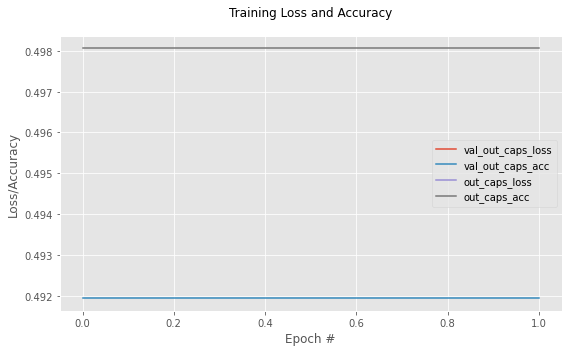


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------------
Testing with kernel kernel sizes 5/7
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 37s 3ms/step - loss: 0.2122 - out_caps_loss: 0.2122 - out_recon_loss: 0.0882 - out_caps_acc: 0.5988 - out_recon_acc: 0.3653 - val_loss: 0.1846 - val_out_caps_loss: 0.1845 - val_out_recon_loss: 0.0846 - val_out_caps_acc: 0.6700 - val_out_recon_acc: 0.4001
Epoch 2/30
13392/13392 [==============================] - 21s 2ms/step - loss: 0.1863 - out_caps_loss: 0.1863 - out_recon_loss: 0.0502 - out_caps_acc: 0.6741 - out_recon_acc: 0.4937 - val_loss: 0.1743 - val_out_caps_loss: 0.1743 - val_out_recon_loss: 0.0353 - val_out_caps_acc: 0.6949 - val_out_recon_acc: 0.5247
Epoch 3/30

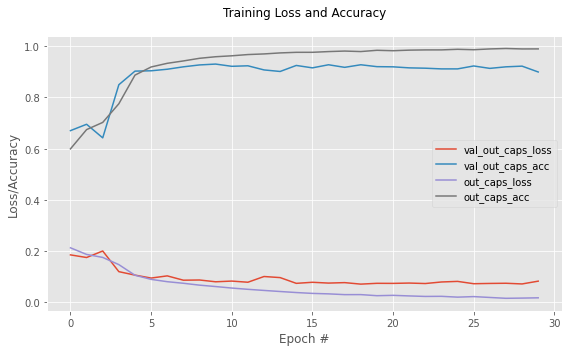


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.081    | 0.899    | 0.891     | 0.909    | 0.900   

-------------------------------------
Testing with kernel kernel sizes 5/9
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 37s 3ms/step - loss: 0.2202 - out_caps_loss: 0.2201 - out_recon_loss: 0.0883 - out_caps_acc: 0.5747 - out_recon_acc: 0.3671 - val_loss: 0.2089 - val_out_caps_loss: 0.2089 - val_out_recon_loss: 0.0852 - val_out_caps_acc: 0.6317 - val_out_recon_acc: 0.4052
Epoch 2/30
13392/13392 [==============================] - 20s 2ms/step - loss: 0.1919 - out_caps_loss: 0.1919 - out_recon_loss: 0.0527 - out_caps_acc: 0.6615 - out_recon_acc: 0.4937 - val_loss: 0.1735 - val_out_caps_loss: 0.1735 - val_out_recon_loss: 0.0352 - val_out_caps_acc: 0.7050 - val_out_recon_acc: 0.5280
Epoch 3/30

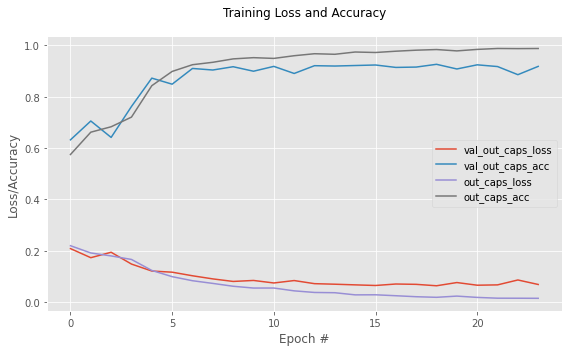


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.066    | 0.915    | 0.906     | 0.925    | 0.916   

-------------------------------------
Testing with kernel kernel sizes 7/9
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 36s 3ms/step - loss: 0.2192 - out_caps_loss: 0.2191 - out_recon_loss: 0.0881 - out_caps_acc: 0.5747 - out_recon_acc: 0.3817 - val_loss: 0.1904 - val_out_caps_loss: 0.1903 - val_out_recon_loss: 0.0836 - val_out_caps_acc: 0.6667 - val_out_recon_acc: 0.4231
Epoch 2/30
13392/13392 [==============================] - 19s 1ms/step - loss: 0.1962 - out_caps_loss: 0.1962 - out_recon_loss: 0.0476 - out_caps_acc: 0.6444 - out_recon_acc: 0.5075 - val_loss: 0.1919 - val_out_caps_loss: 0.1919 - val_out_recon_loss: 0.0353 - val_out_caps_acc: 0.6687 - val_out_recon_acc: 0.5262
Epoch 3/30

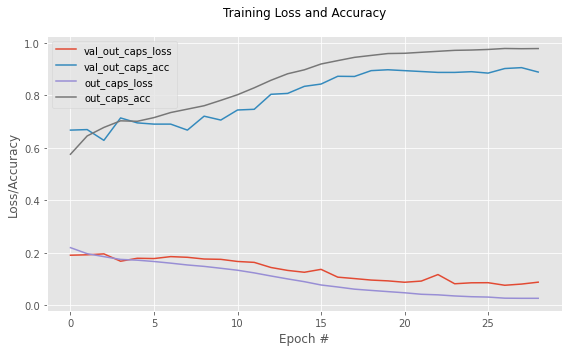


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.082    | 0.898    | 0.856     | 0.956    | 0.903   

-------------------------------------
Testing with kernel kernel sizes 9/9
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 35s 3ms/step - loss: 0.3952 - out_caps_loss: 0.3952 - out_recon_loss: 0.0880 - out_caps_acc: 0.4994 - out_recon_acc: 0.3669 - val_loss: 0.4046 - val_out_caps_loss: 0.4046 - val_out_recon_loss: 0.0831 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.4005
Epoch 2/30
13392/13392 [==============================] - 18s 1ms/step - loss: 0.4039 - out_caps_loss: 0.4039 - out_recon_loss: 0.0464 - out_caps_acc: 0.4926 - out_recon_acc: 0.5042 - val_loss: 0.4041 - val_out_caps_loss: 0.4040 - val_out_recon_loss: 0.0364 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.5238
Epoch 0000

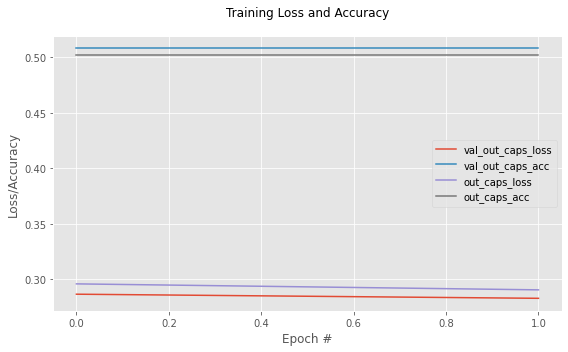


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.287    | 0.500    | 0.500     | 1.000    | 0.667   



In [0]:
klist=[[5,5],
       [5,7], 
       [5,9],
       [7,9],
       [9,9]]

for k_size in klist:
    print("-------------------------------------")
    print("Testing with kernel kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------------")
    (model, scores), hist = CapsTest(k_size, frac=60, bs=128, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=[64,64],
                                    pltFile="6c_CapsnetModel_{}.{}_f64.64.png".format(k_size[0],k_size[1]))
    showScores(scores)
    print("")

##9 Search for Best Filter sizes

-------------------------------
Testing with filter sizes 32/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 48s 4ms/step - loss: 0.2105 - out_caps_loss: 0.2105 - out_recon_loss: 0.0882 - out_caps_acc: 0.6037 - out_recon_acc: 0.3747 - val_loss: 0.1861 - val_out_caps_loss: 0.1861 - val_out_recon_loss: 0.0845 - val_out_caps_acc: 0.6613 - val_out_recon_acc: 0.4082
Epoch 2/30
13392/13392 [==============================] - 30s 2ms/step - loss: 0.1839 - out_caps_loss: 0.1838 - out_recon_loss: 0.0495 - out_caps_acc: 0.6761 - out_recon_acc: 0.5001 - val_loss: 0.1748 - val_out_caps_loss: 0.1748 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.7030 - val_out_recon_acc: 0.5395
Epoch 3/30
13392/13392 [==============================] - 30s 2ms/step - loss: 0.1563 - out_caps_loss: 0.1563 - out_recon_loss: 0.0346 - out_caps_acc: 0.7555 - out_recon_acc: 0.5232 - val_loss: 0.1352 - val_out_caps_loss: 0.1352 

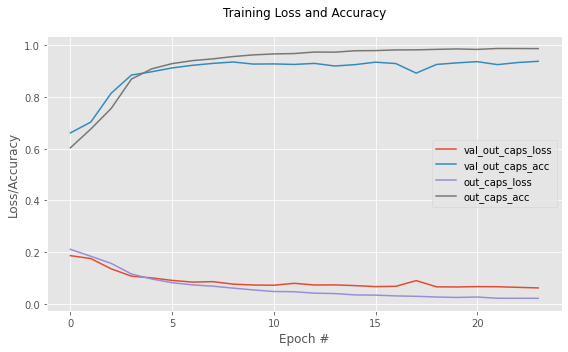


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.072    | 0.922    | 0.929     | 0.914    | 0.921   

-------------------------------
Testing with filter sizes 48/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 48s 4ms/step - loss: 0.4016 - out_caps_loss: 0.4016 - out_recon_loss: 0.0879 - out_caps_acc: 0.5019 - out_recon_acc: 0.3704 - val_loss: 0.3988 - val_out_caps_loss: 0.3987 - val_out_recon_loss: 0.0835 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.4213
Epoch 2/30
13392/13392 [==============================] - 30s 2ms/step - loss: 0.2695 - out_caps_loss: 0.2695 - out_recon_loss: 0.0469 - out_caps_acc: 0.5543 - out_recon_acc: 0.5117 - val_loss: 0.2037 - val_out_caps_loss: 0.2037 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.5995 - val_out_recon_acc: 0.5428
Epoch 3/30
13392/13392 [===

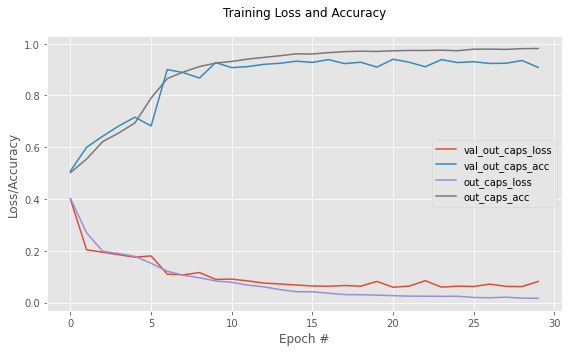


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.086    | 0.893    | 0.911     | 0.872    | 0.891   

-------------------------------
Testing with filter sizes 64/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 48s 4ms/step - loss: 0.2171 - out_caps_loss: 0.2171 - out_recon_loss: 0.0881 - out_caps_acc: 0.5919 - out_recon_acc: 0.3676 - val_loss: 0.2060 - val_out_caps_loss: 0.2059 - val_out_recon_loss: 0.0838 - val_out_caps_acc: 0.6371 - val_out_recon_acc: 0.4057
Epoch 2/30
13392/13392 [==============================] - 29s 2ms/step - loss: 0.1874 - out_caps_loss: 0.1873 - out_recon_loss: 0.0484 - out_caps_acc: 0.6711 - out_recon_acc: 0.4996 - val_loss: 0.1848 - val_out_caps_loss: 0.1848 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6727 - val_out_recon_acc: 0.5370
Epoch 3/30
13392/13392 [===

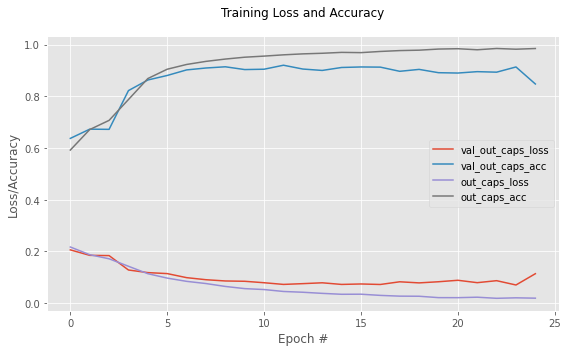


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.109    | 0.852    | 0.801     | 0.936    | 0.863   

-------------------------------
Testing with filter sizes 32/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 60s 5ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0887 - out_caps_acc: 0.4981 - out_recon_acc: 0.4553 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0875 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4546
Epoch 2/30
13392/13392 [==============================] - 41s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0826 - out_caps_acc: 0.4981 - out_recon_acc: 0.4588 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0725 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4979
Epoch 00002: early stopping
Train on 13392 samples

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


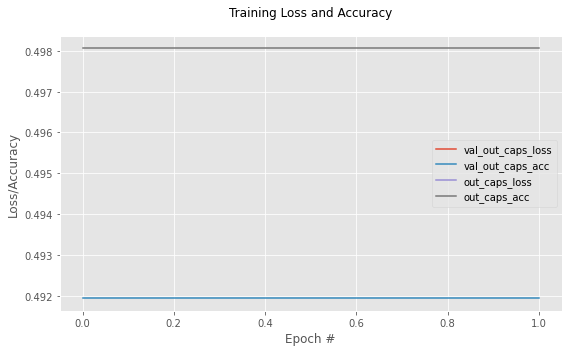


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 48/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 66s 5ms/step - loss: 0.4025 - out_caps_loss: 0.4024 - out_recon_loss: 0.0877 - out_caps_acc: 0.4978 - out_recon_acc: 0.3622 - val_loss: 0.4048 - val_out_caps_loss: 0.4047 - val_out_recon_loss: 0.0818 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4086
Epoch 2/30
13392/13392 [==============================] - 44s 3ms/step - loss: 0.2847 - out_caps_loss: 0.2847 - out_recon_loss: 0.0459 - out_caps_acc: 0.5521 - out_recon_acc: 0.5075 - val_loss: 0.2082 - val_out_caps_loss: 0.2082 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.5773 - val_out_recon_acc: 0.5391
Epoch 3/30
13392/13392 [==

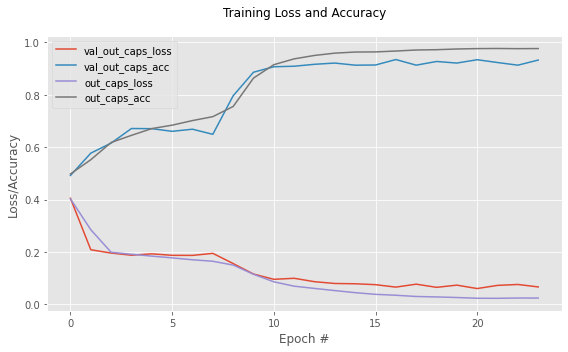


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.084    | 0.905    | 0.932     | 0.873    | 0.901   

-------------------------------
Testing with filter sizes 64/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 66s 5ms/step - loss: 0.2151 - out_caps_loss: 0.2151 - out_recon_loss: 0.0880 - out_caps_acc: 0.5950 - out_recon_acc: 0.3790 - val_loss: 0.1968 - val_out_caps_loss: 0.1968 - val_out_recon_loss: 0.0837 - val_out_caps_acc: 0.6196 - val_out_recon_acc: 0.4216
Epoch 2/30
13392/13392 [==============================] - 43s 3ms/step - loss: 0.1857 - out_caps_loss: 0.1857 - out_recon_loss: 0.0481 - out_caps_acc: 0.6750 - out_recon_acc: 0.5085 - val_loss: 0.1950 - val_out_caps_loss: 0.1950 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6680 - val_out_recon_acc: 0.5424
Epoch 3/30
13392/13392 [==

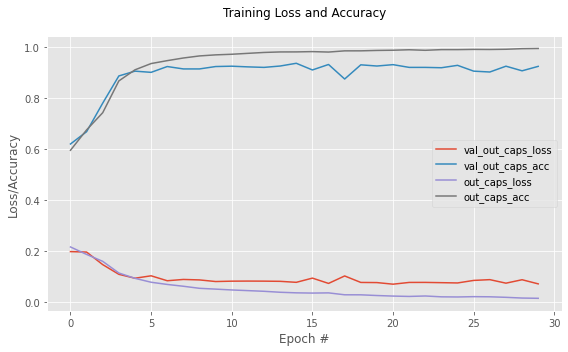


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.074    | 0.909    | 0.917     | 0.898    | 0.908   

-------------------------------
Testing with filter sizes 128/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 67s 5ms/step - loss: 0.4035 - out_caps_loss: 0.4034 - out_recon_loss: 0.0878 - out_caps_acc: 0.4928 - out_recon_acc: 0.3663 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0825 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.4098
Epoch 2/30
13392/13392 [==============================] - 45s 3ms/step - loss: 0.4050 - out_caps_loss: 0.4050 - out_recon_loss: 0.0455 - out_caps_acc: 0.5019 - out_recon_acc: 0.5065 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0342 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.5391
Epoch 00002: early stoppi

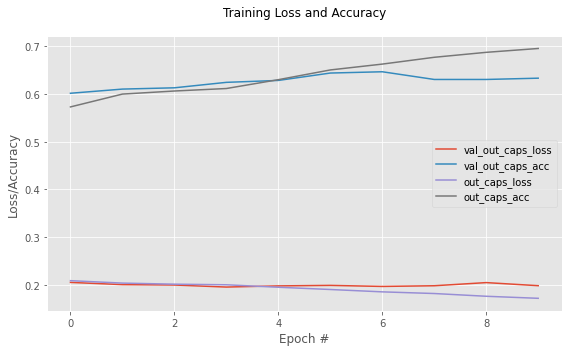


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.196    | 0.648    | 0.631     | 0.713    | 0.669   



In [0]:
flist=[[32,64], 
       [48,64],
       [64,64],
       [32,128],
       [48,128],
       [64,128],
       [128,128]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([5,7], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    pltFile="6c_CapsnetModel_5.9_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 32/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 51s 4ms/step - loss: 0.2107 - out_caps_loss: 0.2106 - out_recon_loss: 0.0879 - out_caps_acc: 0.6053 - out_recon_acc: 0.3666 - val_loss: 0.1839 - val_out_caps_loss: 0.1838 - val_out_recon_loss: 0.0827 - val_out_caps_acc: 0.6781 - val_out_recon_acc: 0.4089
Epoch 2/30
13392/13392 [==============================] - 28s 2ms/step - loss: 0.1580 - out_caps_loss: 0.1580 - out_recon_loss: 0.0462 - out_caps_acc: 0.7884 - out_recon_acc: 0.5027 - val_loss: 0.1408 - val_out_caps_loss: 0.1408 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.8219 - val_out_recon_acc: 0.5363
Epoch 3/30
13392/13392 [==============================] - 28s 2ms/step - loss: 0.1252 - out_caps_loss: 0.1251 - out_recon_loss: 0.0348 - out_caps_acc: 0.8616 - out_recon_acc: 0.5213 - val_loss: 0.1267 - val_out_caps_loss: 0.1267 

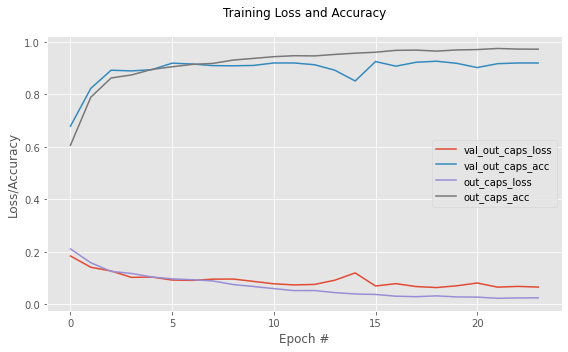


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.078    | 0.904    | 0.913     | 0.893    | 0.903   

-------------------------------
Testing with filter sizes 48/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 51s 4ms/step - loss: 0.2647 - out_caps_loss: 0.2647 - out_recon_loss: 0.0880 - out_caps_acc: 0.5500 - out_recon_acc: 0.3761 - val_loss: 0.2072 - val_out_caps_loss: 0.2072 - val_out_recon_loss: 0.0830 - val_out_caps_acc: 0.6190 - val_out_recon_acc: 0.4257
Epoch 2/30
13392/13392 [==============================] - 28s 2ms/step - loss: 0.1992 - out_caps_loss: 0.1992 - out_recon_loss: 0.0470 - out_caps_acc: 0.6290 - out_recon_acc: 0.5083 - val_loss: 0.1891 - val_out_caps_loss: 0.1891 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6727 - val_out_recon_acc: 0.5388
Epoch 3/30
13392/13392 [===

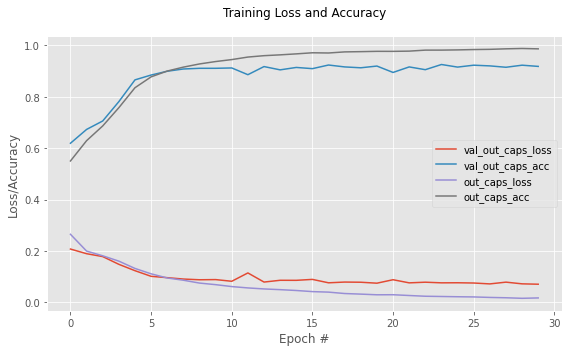


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.083    | 0.903    | 0.915     | 0.888    | 0.901   

-------------------------------
Testing with filter sizes 64/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 53s 4ms/step - loss: 0.2331 - out_caps_loss: 0.2331 - out_recon_loss: 0.0881 - out_caps_acc: 0.5707 - out_recon_acc: 0.3734 - val_loss: 0.2040 - val_out_caps_loss: 0.2040 - val_out_recon_loss: 0.0838 - val_out_caps_acc: 0.6411 - val_out_recon_acc: 0.4124
Epoch 2/30
13392/13392 [==============================] - 29s 2ms/step - loss: 0.1915 - out_caps_loss: 0.1915 - out_recon_loss: 0.0479 - out_caps_acc: 0.6588 - out_recon_acc: 0.5060 - val_loss: 0.1839 - val_out_caps_loss: 0.1839 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6788 - val_out_recon_acc: 0.5410
Epoch 3/30
13392/13392 [===

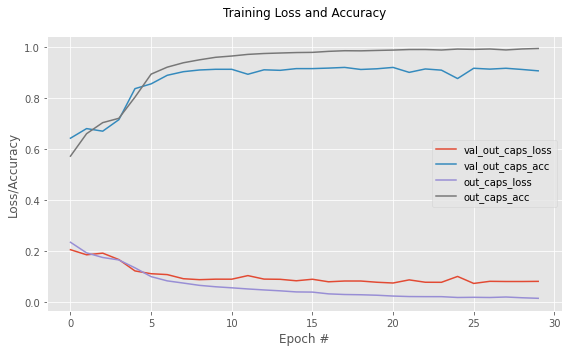


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.081    | 0.900    | 0.891     | 0.912    | 0.901   

-------------------------------
Testing with filter sizes 32/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 62s 5ms/step - loss: 0.4053 - out_caps_loss: 0.4053 - out_recon_loss: 0.0875 - out_caps_acc: 0.4997 - out_recon_acc: 0.3667 - val_loss: 0.4050 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0799 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.4191
Epoch 2/30
13392/13392 [==============================] - 38s 3ms/step - loss: 0.4049 - out_caps_loss: 0.4049 - out_recon_loss: 0.0426 - out_caps_acc: 0.5019 - out_recon_acc: 0.5177 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0342 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.5407
Epoch 00002: early stoppin

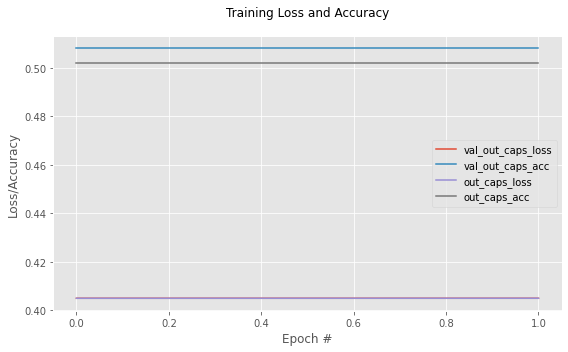


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.405    | 0.500    | 0.500     | 1.000    | 0.667   

-------------------------------
Testing with filter sizes 48/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 66s 5ms/step - loss: 0.2184 - out_caps_loss: 0.2183 - out_recon_loss: 0.0882 - out_caps_acc: 0.5901 - out_recon_acc: 0.3675 - val_loss: 0.1959 - val_out_caps_loss: 0.1958 - val_out_recon_loss: 0.0848 - val_out_caps_acc: 0.6337 - val_out_recon_acc: 0.4076
Epoch 2/30
13392/13392 [==============================] - 38s 3ms/step - loss: 0.1866 - out_caps_loss: 0.1866 - out_recon_loss: 0.0503 - out_caps_acc: 0.6660 - out_recon_acc: 0.4947 - val_loss: 0.1847 - val_out_caps_loss: 0.1847 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.6707 - val_out_recon_acc: 0.5364
Epoch 3/30
13392/13392 [==

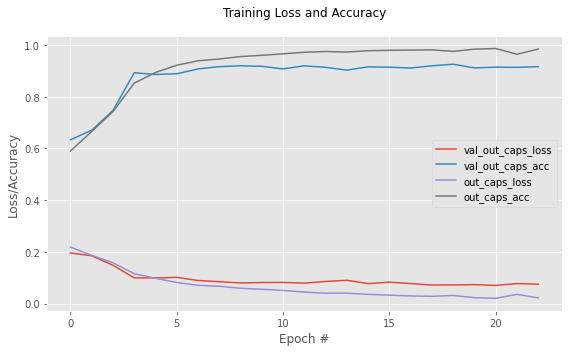


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.078    | 0.906    | 0.907     | 0.906    | 0.906   

-------------------------------
Testing with filter sizes 64/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 66s 5ms/step - loss: 0.2181 - out_caps_loss: 0.2180 - out_recon_loss: 0.0881 - out_caps_acc: 0.5883 - out_recon_acc: 0.3656 - val_loss: 0.1966 - val_out_caps_loss: 0.1966 - val_out_recon_loss: 0.0839 - val_out_caps_acc: 0.6485 - val_out_recon_acc: 0.4054
Epoch 2/30
13392/13392 [==============================] - 39s 3ms/step - loss: 0.1902 - out_caps_loss: 0.1902 - out_recon_loss: 0.0484 - out_caps_acc: 0.6600 - out_recon_acc: 0.5009 - val_loss: 0.1929 - val_out_caps_loss: 0.1929 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6559 - val_out_recon_acc: 0.5390
Epoch 3/30
13392/13392 [==

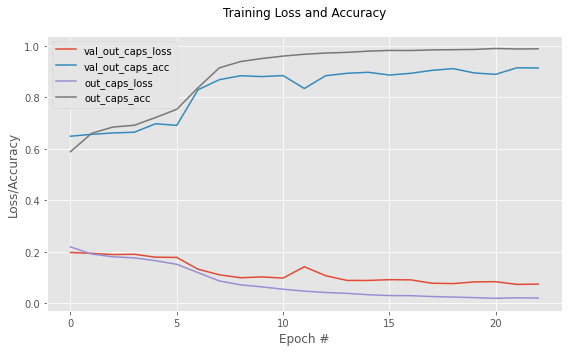


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.080    | 0.905    | 0.916     | 0.891    | 0.904   

-------------------------------
Testing with filter sizes 128/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 68s 5ms/step - loss: 0.2188 - out_caps_loss: 0.2188 - out_recon_loss: 0.0881 - out_caps_acc: 0.5703 - out_recon_acc: 0.3649 - val_loss: 0.2010 - val_out_caps_loss: 0.2009 - val_out_recon_loss: 0.0841 - val_out_caps_acc: 0.6398 - val_out_recon_acc: 0.4031
Epoch 2/30
13392/13392 [==============================] - 41s 3ms/step - loss: 0.1915 - out_caps_loss: 0.1915 - out_recon_loss: 0.0487 - out_caps_acc: 0.6511 - out_recon_acc: 0.4982 - val_loss: 0.1969 - val_out_caps_loss: 0.1969 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.6398 - val_out_recon_acc: 0.5362
Epoch 3/30
13392/13392 [=

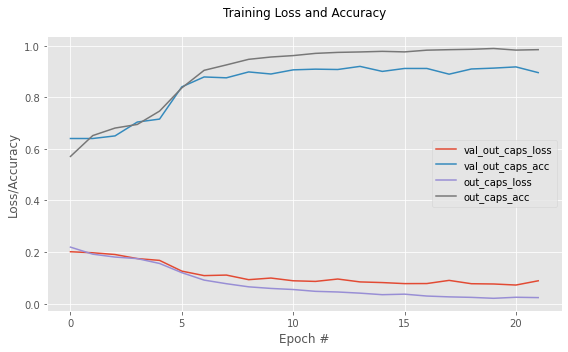


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.090    | 0.892    | 0.881     | 0.906    | 0.893   



In [0]:
flist=[[32,64], 
       [48,64],
       [64,64],
       [32,128],
       [48,128],
       [64,128],
       [128,128]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([5,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    pltFile="6c_CapsnetModel_5.9_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 32/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 47s 4ms/step - loss: 0.3965 - out_caps_loss: 0.3964 - out_recon_loss: 0.0878 - out_caps_acc: 0.5042 - out_recon_acc: 0.3658 - val_loss: 0.4040 - val_out_caps_loss: 0.4040 - val_out_recon_loss: 0.0824 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4144
Epoch 2/30
13392/13392 [==============================] - 31s 2ms/step - loss: 0.4031 - out_caps_loss: 0.4031 - out_recon_loss: 0.0469 - out_caps_acc: 0.5062 - out_recon_acc: 0.5063 - val_loss: 0.4048 - val_out_caps_loss: 0.4048 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.5406
Epoch 00002: early stopping
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 48s 4ms/step - loss: 0.4048 - out_caps_loss: 0.4048 - out_recon_loss: 0.0349 - out_caps_acc: 0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


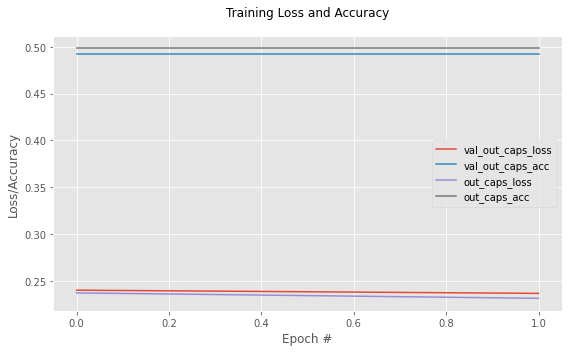


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.240    | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 48/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 53s 4ms/step - loss: 0.3979 - out_caps_loss: 0.3979 - out_recon_loss: 0.0877 - out_caps_acc: 0.5004 - out_recon_acc: 0.3620 - val_loss: 0.4048 - val_out_caps_loss: 0.4047 - val_out_recon_loss: 0.0815 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.4085
Epoch 2/30
13392/13392 [==============================] - 34s 3ms/step - loss: 0.4038 - out_caps_loss: 0.4038 - out_recon_loss: 0.0451 - out_caps_acc: 0.5019 - out_recon_acc: 0.5041 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.5355
Epoch 00002: early stopping

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


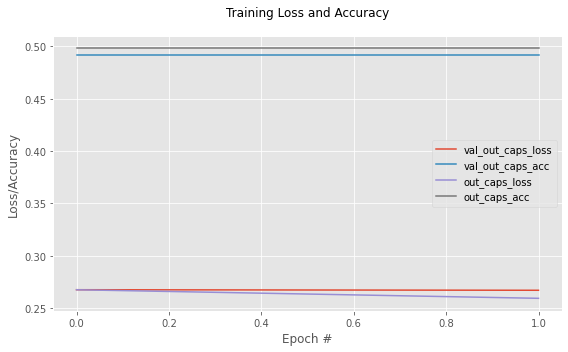


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.263    | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 64/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 53s 4ms/step - loss: 0.3986 - out_caps_loss: 0.3985 - out_recon_loss: 0.0877 - out_caps_acc: 0.5043 - out_recon_acc: 0.3652 - val_loss: 0.4039 - val_out_caps_loss: 0.4039 - val_out_recon_loss: 0.0831 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.4217
Epoch 2/30
13392/13392 [==============================] - 31s 2ms/step - loss: 0.4008 - out_caps_loss: 0.4008 - out_recon_loss: 0.0476 - out_caps_acc: 0.4972 - out_recon_acc: 0.5053 - val_loss: 0.3707 - val_out_caps_loss: 0.3707 - val_out_recon_loss: 0.0351 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.5357
Epoch 00002: early stopping

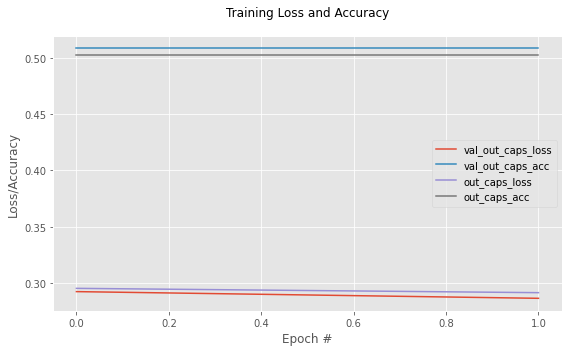


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.291    | 0.500    | 0.500     | 1.000    | 0.667   

-------------------------------
Testing with filter sizes 32/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 65s 5ms/step - loss: 0.4052 - out_caps_loss: 0.4051 - out_recon_loss: 0.0868 - out_caps_acc: 0.5065 - out_recon_acc: 0.3626 - val_loss: 0.4049 - val_out_caps_loss: 0.4048 - val_out_recon_loss: 0.0741 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.4274
Epoch 2/30
13392/13392 [==============================] - 40s 3ms/step - loss: 0.4047 - out_caps_loss: 0.4046 - out_recon_loss: 0.0426 - out_caps_acc: 0.4932 - out_recon_acc: 0.5179 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.5387
Epoch 00002: early stoppin

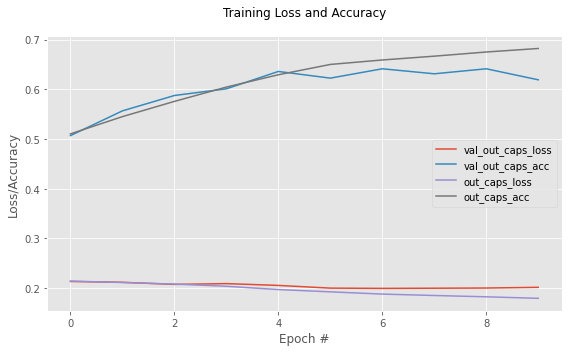


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.200    | 0.622    | 0.696     | 0.433    | 0.534   

-------------------------------
Testing with filter sizes 48/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 66s 5ms/step - loss: 0.2237 - out_caps_loss: 0.2237 - out_recon_loss: 0.0883 - out_caps_acc: 0.5618 - out_recon_acc: 0.3695 - val_loss: 0.2022 - val_out_caps_loss: 0.2021 - val_out_recon_loss: 0.0853 - val_out_caps_acc: 0.6317 - val_out_recon_acc: 0.4083
Epoch 2/30
13392/13392 [==============================] - 40s 3ms/step - loss: 0.2002 - out_caps_loss: 0.2002 - out_recon_loss: 0.0528 - out_caps_acc: 0.6433 - out_recon_acc: 0.4968 - val_loss: 0.1897 - val_out_caps_loss: 0.1897 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6747 - val_out_recon_acc: 0.5424
Epoch 3/30
13392/13392 [==

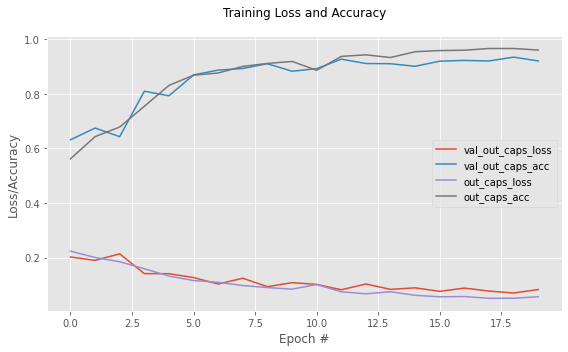


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.082    | 0.917    | 0.921     | 0.912    | 0.917   



In [0]:
flist=[[32,64], 
       [48,64],
       [64,64],
       [32,128],
       [48,128]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([9,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    pltFile="6c_CapsnetModel_5.9_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 8/16
-------------------------------



Instructions for updating:
dim is deprecated, use axis instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 13392 samples, validate on 1488 samples
Epoch 1/30




13392/13392 [==============================] - 35s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0887 - out_caps_acc: 0.4978 - out_recon_acc: 0.4708 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0875 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4696
Epoch 2/30
13392/13392 [==============================] - 22s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0825 - out_caps_acc: 0.4981 - out_recon_acc: 0.4716 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0723 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.5082
Epoch 00002: early stopping
Train on 13392 samples, validate on 1488 samples
Epoch 1/3

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


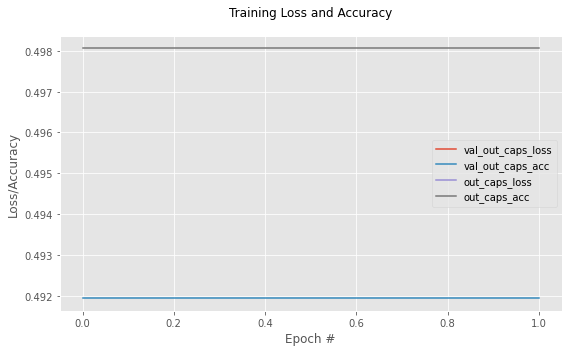


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 28s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0887 - out_caps_acc: 0.4980 - out_recon_acc: 0.4641 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0874 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4651
Epoch 2/30
13392/13392 [==============================] - 25s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0820 - out_caps_acc: 0.4981 - out_recon_acc: 0.4727 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0709 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.5114
Epoch 00002: early stopping
Train on 13392 samples,

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


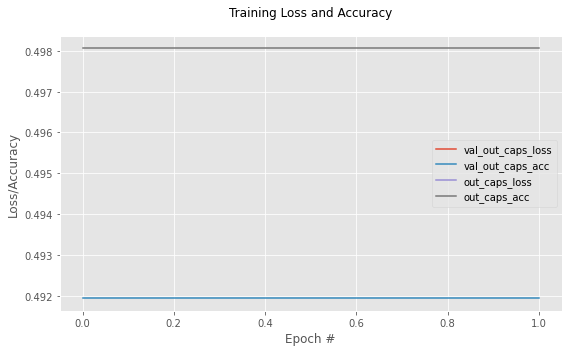


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 16/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 34s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0887 - out_caps_acc: 0.4975 - out_recon_acc: 0.4663 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0875 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4660
Epoch 2/30
13392/13392 [==============================] - 28s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0823 - out_caps_acc: 0.4981 - out_recon_acc: 0.4706 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0718 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.5133
Epoch 00002: early stopping
Train on 13392 samples,

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


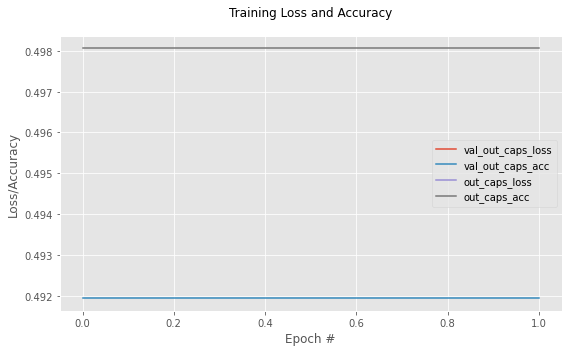


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 24/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 37s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0887 - out_caps_acc: 0.4978 - out_recon_acc: 0.4644 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0875 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4628
Epoch 2/30
13392/13392 [==============================] - 28s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0825 - out_caps_acc: 0.4981 - out_recon_acc: 0.4660 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0723 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.5024
Epoch 00002: early stopping
Train on 13392 samples,

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


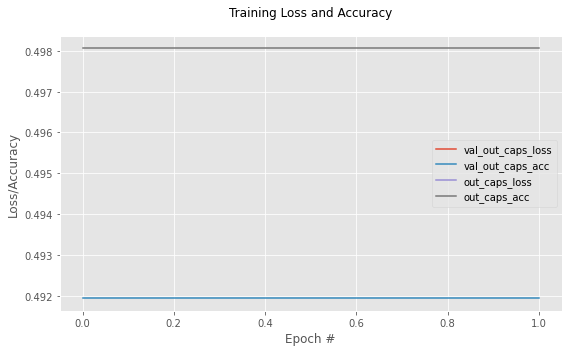


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   



In [0]:
flist=[[8,16], 
       [16,32],
       [16,48],
       [24,48]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([5,7], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    pltFile="6c_CapsnetModel_5.7_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 31s 2ms/step - loss: 0.2032 - out_caps_loss: 0.2032 - out_recon_loss: 0.0882 - out_caps_acc: 0.6253 - out_recon_acc: 0.3750 - val_loss: 0.1814 - val_out_caps_loss: 0.1814 - val_out_recon_loss: 0.0849 - val_out_caps_acc: 0.6942 - val_out_recon_acc: 0.4123
Epoch 2/30
13392/13392 [==============================] - 21s 2ms/step - loss: 0.1785 - out_caps_loss: 0.1784 - out_recon_loss: 0.0511 - out_caps_acc: 0.6988 - out_recon_acc: 0.4997 - val_loss: 0.1698 - val_out_caps_loss: 0.1698 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.7285 - val_out_recon_acc: 0.5443
Epoch 3/30
13392/13392 [==============================] - 21s 2ms/step - loss: 0.1607 - out_caps_loss: 0.1607 - out_recon_loss: 0.0346 - out_caps_acc: 0.7483 - out_recon_acc: 0.5281 - val_loss: 0.1724 - val_out_caps_loss: 0.1724 -

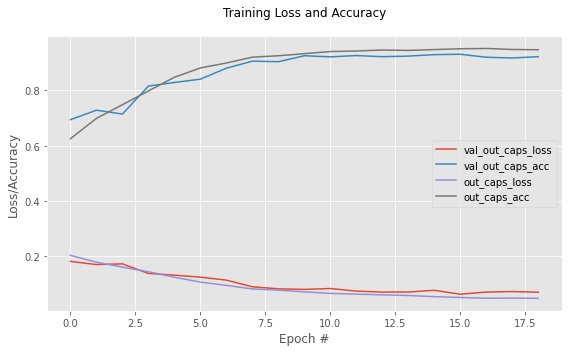


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.073    | 0.912    | 0.916     | 0.906    | 0.911   

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 34s 3ms/step - loss: 0.2099 - out_caps_loss: 0.2099 - out_recon_loss: 0.0881 - out_caps_acc: 0.5969 - out_recon_acc: 0.3713 - val_loss: 0.1977 - val_out_caps_loss: 0.1976 - val_out_recon_loss: 0.0842 - val_out_caps_acc: 0.6694 - val_out_recon_acc: 0.4084
Epoch 2/30
13392/13392 [==============================] - 24s 2ms/step - loss: 0.1868 - out_caps_loss: 0.1868 - out_recon_loss: 0.0494 - out_caps_acc: 0.6760 - out_recon_acc: 0.4975 - val_loss: 0.1743 - val_out_caps_loss: 0.1742 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.6996 - val_out_recon_acc: 0.5372
Epoch 3/30
13392/13392 [===

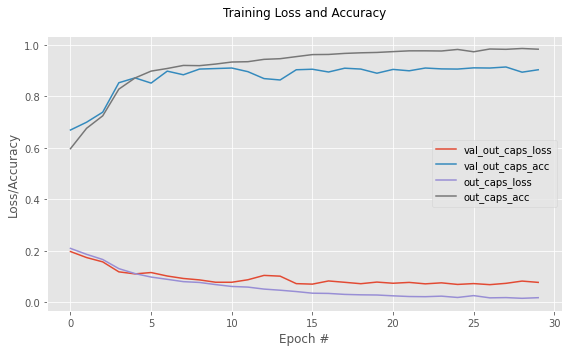


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.076    | 0.904    | 0.887     | 0.926    | 0.906   

-------------------------------
Testing with filter sizes 16/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 38s 3ms/step - loss: 0.2116 - out_caps_loss: 0.2116 - out_recon_loss: 0.0880 - out_caps_acc: 0.6024 - out_recon_acc: 0.3717 - val_loss: 0.2011 - val_out_caps_loss: 0.2010 - val_out_recon_loss: 0.0834 - val_out_caps_acc: 0.6210 - val_out_recon_acc: 0.4107
Epoch 2/30
13392/13392 [==============================] - 27s 2ms/step - loss: 0.1867 - out_caps_loss: 0.1866 - out_recon_loss: 0.0475 - out_caps_acc: 0.6783 - out_recon_acc: 0.5058 - val_loss: 0.1835 - val_out_caps_loss: 0.1835 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.6815 - val_out_recon_acc: 0.5413
Epoch 3/30
13392/13392 [===

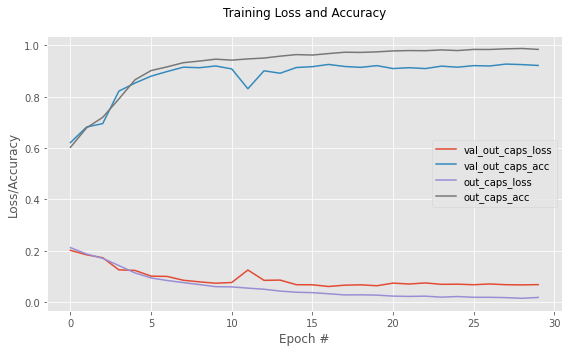


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.072    | 0.914    | 0.902     | 0.930    | 0.916   

-------------------------------
Testing with filter sizes 24/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 40s 3ms/step - loss: 0.2170 - out_caps_loss: 0.2169 - out_recon_loss: 0.0881 - out_caps_acc: 0.5850 - out_recon_acc: 0.3772 - val_loss: 0.2040 - val_out_caps_loss: 0.2040 - val_out_recon_loss: 0.0837 - val_out_caps_acc: 0.6297 - val_out_recon_acc: 0.4168
Epoch 2/30
13392/13392 [==============================] - 28s 2ms/step - loss: 0.1933 - out_caps_loss: 0.1932 - out_recon_loss: 0.0484 - out_caps_acc: 0.6511 - out_recon_acc: 0.5044 - val_loss: 0.1923 - val_out_caps_loss: 0.1923 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6613 - val_out_recon_acc: 0.5392
Epoch 3/30
13392/13392 [===

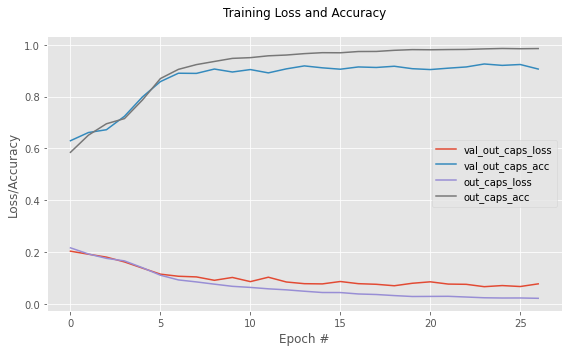


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.085    | 0.903    | 0.889     | 0.922    | 0.905   



In [0]:
flist=[[8,16], 
       [16,32],
       [16,48],
       [24,48]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([5,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    pltFile="6c_CapsnetModel_5.9_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 34s 3ms/step - loss: 0.2223 - out_caps_loss: 0.2223 - out_recon_loss: 0.0883 - out_caps_acc: 0.5531 - out_recon_acc: 0.3707 - val_loss: 0.2054 - val_out_caps_loss: 0.2054 - val_out_recon_loss: 0.0852 - val_out_caps_acc: 0.6062 - val_out_recon_acc: 0.4121
Epoch 2/30
13392/13392 [==============================] - 21s 2ms/step - loss: 0.2005 - out_caps_loss: 0.2005 - out_recon_loss: 0.0513 - out_caps_acc: 0.6194 - out_recon_acc: 0.4935 - val_loss: 0.1926 - val_out_caps_loss: 0.1926 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6384 - val_out_recon_acc: 0.5377
Epoch 3/30
13392/13392 [==============================] - 22s 2ms/step - loss: 0.1862 - out_caps_loss: 0.1862 - out_recon_loss: 0.0346 - out_caps_acc: 0.6696 - out_recon_acc: 0.5238 - val_loss: 0.1864 - val_out_caps_loss: 0.1864 -

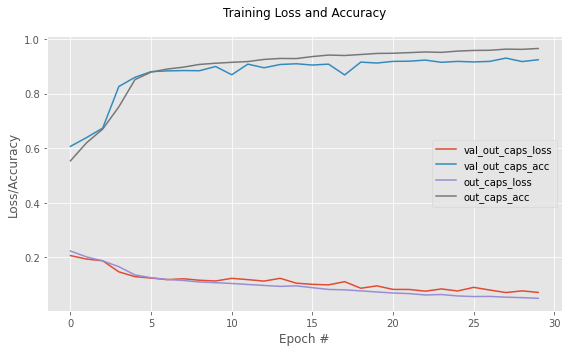


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.073    | 0.914    | 0.919     | 0.908    | 0.913   

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 39s 3ms/step - loss: 0.2148 - out_caps_loss: 0.2148 - out_recon_loss: 0.0881 - out_caps_acc: 0.5665 - out_recon_acc: 0.3672 - val_loss: 0.2069 - val_out_caps_loss: 0.2069 - val_out_recon_loss: 0.0845 - val_out_caps_acc: 0.5981 - val_out_recon_acc: 0.4101
Epoch 2/30
13392/13392 [==============================] - 23s 2ms/step - loss: 0.1935 - out_caps_loss: 0.1935 - out_recon_loss: 0.0493 - out_caps_acc: 0.6502 - out_recon_acc: 0.4950 - val_loss: 0.1840 - val_out_caps_loss: 0.1840 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6848 - val_out_recon_acc: 0.5354
Epoch 3/30
13392/13392 [===

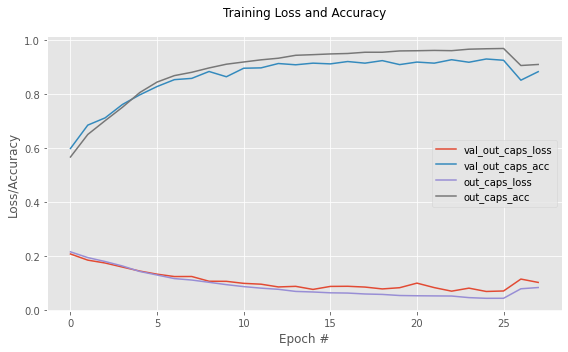


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.103    | 0.883    | 0.889     | 0.876    | 0.882   

-------------------------------
Testing with filter sizes 16/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 40s 3ms/step - loss: 0.2427 - out_caps_loss: 0.2426 - out_recon_loss: 0.0883 - out_caps_acc: 0.5453 - out_recon_acc: 0.3762 - val_loss: 0.2161 - val_out_caps_loss: 0.2161 - val_out_recon_loss: 0.0858 - val_out_caps_acc: 0.5491 - val_out_recon_acc: 0.4193
Epoch 2/30
13392/13392 [==============================] - 26s 2ms/step - loss: 0.2075 - out_caps_loss: 0.2075 - out_recon_loss: 0.0541 - out_caps_acc: 0.5924 - out_recon_acc: 0.4943 - val_loss: 0.2073 - val_out_caps_loss: 0.2073 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.6028 - val_out_recon_acc: 0.5416
Epoch 3/30
13392/13392 [===

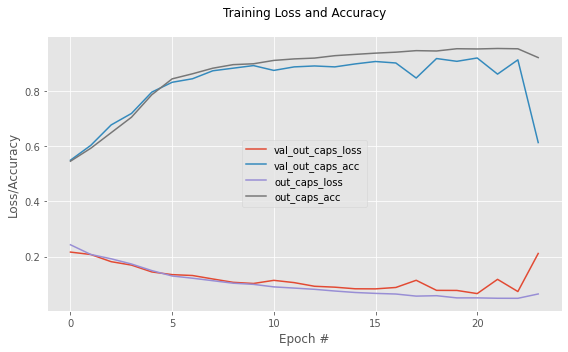


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.210    | 0.608    | 0.636     | 0.508    | 0.565   

-------------------------------
Testing with filter sizes 24/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 45s 3ms/step - loss: 0.3946 - out_caps_loss: 0.3946 - out_recon_loss: 0.0879 - out_caps_acc: 0.5021 - out_recon_acc: 0.3709 - val_loss: 0.4040 - val_out_caps_loss: 0.4040 - val_out_recon_loss: 0.0840 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.4191
Epoch 2/30
13392/13392 [==============================] - 30s 2ms/step - loss: 0.4026 - out_caps_loss: 0.4025 - out_recon_loss: 0.0481 - out_caps_acc: 0.5057 - out_recon_acc: 0.5052 - val_loss: 0.4027 - val_out_caps_loss: 0.4027 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.5371
Epoch 00002: early stopping

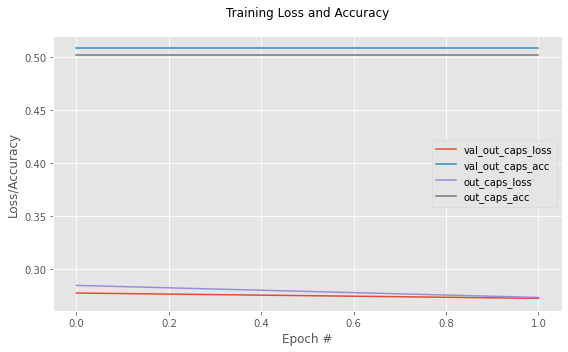


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.273    | 0.500    | 0.500     | 1.000    | 0.667   



In [0]:
flist=[[8,16], 
       [16,32],
       [16,48],
       [24,48]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([9,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    pltFile="6c_CapsnetModel_5.9_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

##10. Test with all data

-------------------------------
Testing with filter sizes 4/8
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 38s 2ms/step - loss: 0.1965 - out_caps_loss: 0.1964 - out_recon_loss: 0.0756 - out_caps_acc: 0.6350 - out_recon_acc: 0.4133 - val_loss: 0.1700 - val_out_caps_loss: 0.1700 - val_out_recon_loss: 0.0359 - val_out_caps_acc: 0.7037 - val_out_recon_acc: 0.5341
Epoch 2/30
22321/22321 [==============================] - 20s 898us/step - loss: 0.1650 - out_caps_loss: 0.1650 - out_recon_loss: 0.0346 - out_caps_acc: 0.7459 - out_recon_acc: 0.5263 - val_loss: 0.1604 - val_out_caps_loss: 0.1604 - val_out_recon_loss: 0.0352 - val_out_caps_acc: 0.7977 - val_out_recon_acc: 0.5136
Epoch 3/30
22321/22321 [==============================] - 21s 930us/step - loss: 0.1388 - out_caps_loss: 0.1388 - out_recon_loss: 0.0345 - out_caps_acc: 0.8254 - out_recon_acc: 0.5150 - val_loss: 0.1302 - val_out_caps_loss: 0.130

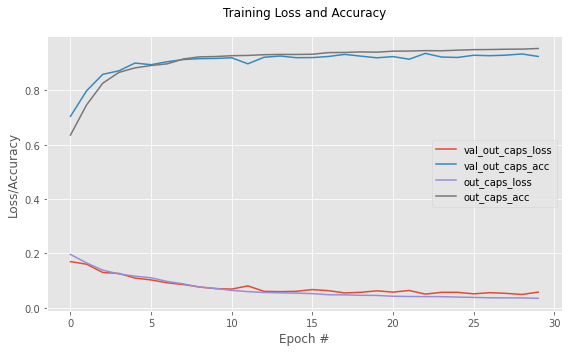


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.056    | 0.931    | 0.922     | 0.942    | 0.932   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.051    | 0.934    | 0.955     | 0.911    | 0.932   

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 41s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0872 - out_caps_acc: 0.5002 - out_recon_acc: 0.4682 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0815 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4762
Epoch 2/30
22321/22321 [==============================] - 22s 999us/step - loss: nan - out_caps_loss: nan - out_recon_

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


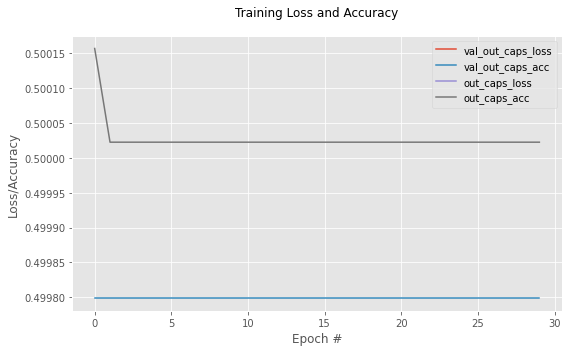


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 44s 2ms/step - loss: 0.2026 - out_caps_loss: 0.2026 - out_recon_loss: 0.0759 - out_caps_acc: 0.6375 - out_recon_acc: 0.4266 - val_loss: 0.1747 - val_out_caps_loss: 0.1747 - val_out_recon_loss: 0.0358 - val_out_caps_acc: 0.7001 - val_out_recon_acc: 0.5372
Epoch 2/30
22321/22321 [==============================] - 25s 1ms/step - loss: 0.1605 - out_caps_loss: 0.1605 - out_recon_loss: 0.0347 - out_caps_acc: 0.7548 - out_recon_acc: 0.5281 - val_loss: 0.1500 - val_out_caps_loss: 0.1500 - val_out_recon_loss: 0.0351 - val_out_caps_acc: 0.8142 - val_out_recon_acc: 

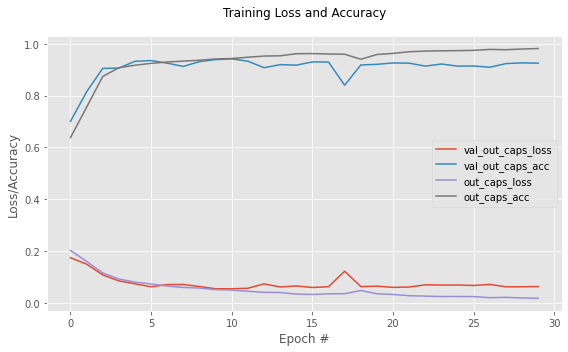


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.056    | 0.933    | 0.917     | 0.951    | 0.934   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.056    | 0.939    | 0.954     | 0.922    | 0.938   

-------------------------------
Testing with filter sizes 24/48
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 48s 2ms/step - loss: 0.2253 - out_caps_loss: 0.2253 - out_recon_loss: 0.0760 - out_caps_acc: 0.5970 - out_recon_acc: 0.4245 - val_loss: 0.1839 - val_out_caps_loss: 0.1839 - val_out_recon_loss: 0.0360 - val_out_caps_acc: 0.6977 - val_out_recon_acc: 0.5352
Epoch 2/30
22321/22321 [==============================] - 29s 1ms/step - loss: 0.1624 - out_caps_loss: 0.

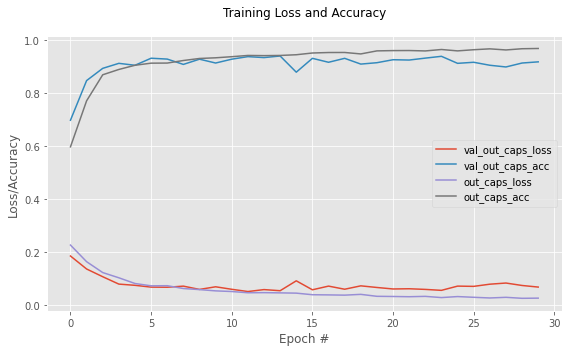


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.064    | 0.922    | 0.918     | 0.928    | 0.923   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.054    | 0.931    | 0.930     | 0.932    | 0.931   

-------------------------------
Testing with filter sizes 32/64
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 52s 2ms/step - loss: 0.2140 - out_caps_loss: 0.2140 - out_recon_loss: 0.0756 - out_caps_acc: 0.6069 - out_recon_acc: 0.4252 - val_loss: 0.1882 - val_out_caps_loss: 0.1882 - val_out_recon_loss: 0.0357 - val_out_caps_acc: 0.6687 - val_out_recon_acc: 0.5359
Epoch 2/30
22321/22321 [==============================] - 32s 1ms/step - loss: 0.1846 - out_caps_loss: 0.

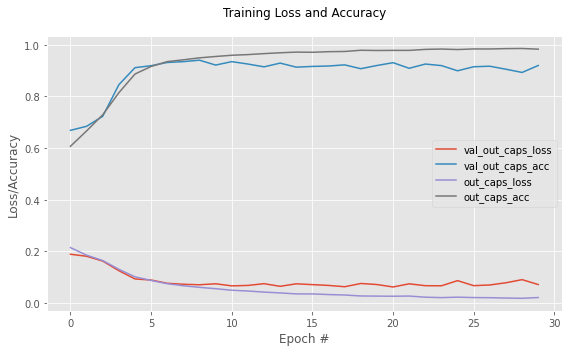


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.066    | 0.920    | 0.899     | 0.946    | 0.922   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.061    | 0.932    | 0.944     | 0.918    | 0.931   

-------------------------------
Testing with filter sizes 64/64
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 53s 2ms/step - loss: 0.2085 - out_caps_loss: 0.2085 - out_recon_loss: 0.0751 - out_caps_acc: 0.6019 - out_recon_acc: 0.4247 - val_loss: 0.1783 - val_out_caps_loss: 0.1783 - val_out_recon_loss: 0.0357 - val_out_caps_acc: 0.6977 - val_out_recon_acc: 0.5326
Epoch 2/30
22321/22321 [==============================] - 33s 1ms/step - loss: 0.1785 - out_caps_loss: 0.

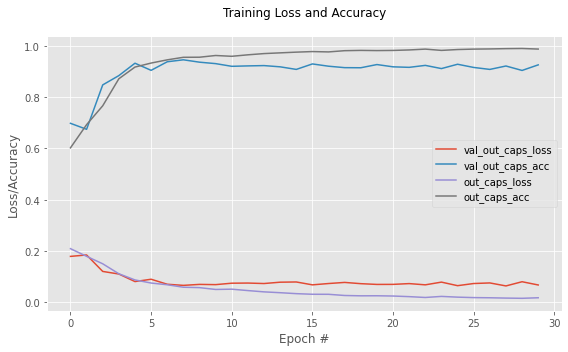


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.058    | 0.933    | 0.917     | 0.952    | 0.934   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.056    | 0.931    | 0.934     | 0.927    | 0.930   



In [0]:
flist=[[4,8],
       [8,16],
       [16,32],
       [24,48],
       [32,64],
       [64,64]]

for f_size in flist:
      print("-------------------------------")
      print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
      print("-------------------------------")
      (model, scores), hist = CapsTest([5,9], 
                                      frac=100, 
                                      bs=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      plot = True, 
                                      f_sizes=f_size,
                                      es=False,
                                      pltFile="6c_CapsnetModel_5.9_frac100_f{}.{}.png".format(f_size[0],f_size[1]),
                                      bestFile="test_{}.{}.h5".format(f_size[0],f_size[1]))
      showScores(scores)

      print("")
      print("Best model (min val loss) scores")
      try:
          model.load_weights("test_{}.{}.h5".format(f_size[0],f_size[1]))
          showModelScores(model, test_X, test_Y)
      except:
          pass
      print("") 

-------------------------------
Testing with filter sizes 4/8
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 39s 2ms/step - loss: 0.2113 - out_caps_loss: 0.2113 - out_recon_loss: 0.0766 - out_caps_acc: 0.5720 - out_recon_acc: 0.4249 - val_loss: 0.1861 - val_out_caps_loss: 0.1861 - val_out_recon_loss: 0.0358 - val_out_caps_acc: 0.6574 - val_out_recon_acc: 0.5361
Epoch 2/30
22321/22321 [==============================] - 19s 867us/step - loss: 0.1700 - out_caps_loss: 0.1700 - out_recon_loss: 0.0346 - out_caps_acc: 0.7228 - out_recon_acc: 0.5253 - val_loss: 0.1636 - val_out_caps_loss: 0.1636 - val_out_recon_loss: 0.0350 - val_out_caps_acc: 0.7622 - val_out_recon_acc: 0.5123
Epoch 3/30
22321/22321 [==============================] - 19s 870us/step - loss: 0.1439 - out_caps_loss: 0.1439 - out_recon_loss: 0.0344 - out_caps_acc: 0.8168 - out_recon_acc: 0.5133 - val_loss: 0.1454 - val_out_caps_loss: 0.145

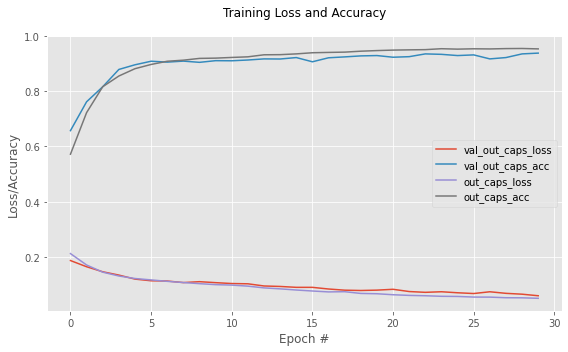


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.060    | 0.936    | 0.949     | 0.922    | 0.935   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.060    | 0.936    | 0.949     | 0.922    | 0.935   

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 42s 2ms/step - loss: 0.2050 - out_caps_loss: 0.2050 - out_recon_loss: 0.0760 - out_caps_acc: 0.6077 - out_recon_acc: 0.4244 - val_loss: 0.1831 - val_out_caps_loss: 0.1831 - val_out_recon_loss: 0.0358 - val_out_caps_acc: 0.6941 - val_out_recon_acc: 0.5360
Epoch 2/30
22321/22321 [==============================] - 21s 949us/step - loss: 0.1742 - out_caps_loss: 0

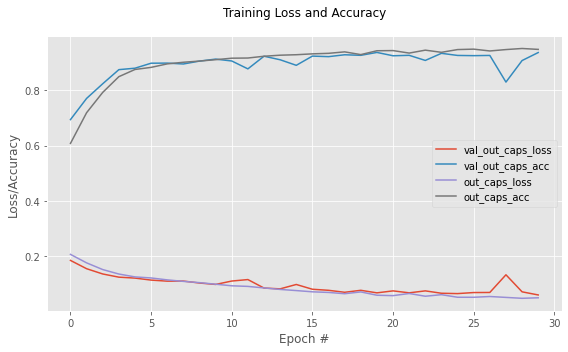


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.054    | 0.937    | 0.937     | 0.936    | 0.936   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.054    | 0.937    | 0.937     | 0.936    | 0.936   

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 44s 2ms/step - loss: 0.2106 - out_caps_loss: 0.2105 - out_recon_loss: 0.0748 - out_caps_acc: 0.5923 - out_recon_acc: 0.4206 - val_loss: 0.1960 - val_out_caps_loss: 0.1960 - val_out_recon_loss: 0.0360 - val_out_caps_acc: 0.6461 - val_out_recon_acc: 0.5324
Epoch 2/30
22321/22321 [==============================] - 24s 1ms/step - loss: 0.1825 - out_caps_loss: 0.

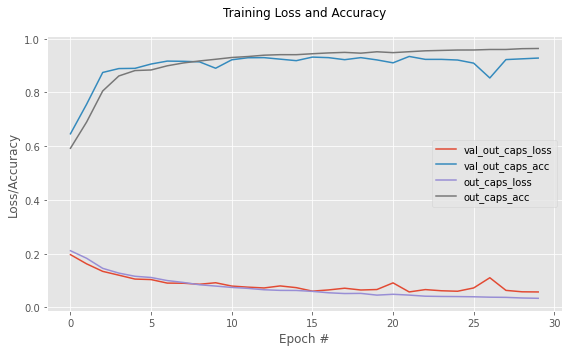


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.057    | 0.932    | 0.929     | 0.935    | 0.932   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.057    | 0.932    | 0.929     | 0.935    | 0.932   

-------------------------------
Testing with filter sizes 24/48
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 48s 2ms/step - loss: 0.3890 - out_caps_loss: 0.3890 - out_recon_loss: 0.0744 - out_caps_acc: 0.4991 - out_recon_acc: 0.4221 - val_loss: 0.4040 - val_out_caps_loss: 0.4039 - val_out_recon_loss: 0.0356 - val_out_caps_acc: 0.5002 - val_out_recon_acc: 0.5340
Epoch 2/30
22321/22321 [==============================] - 28s 1ms/step - loss: 0.4031 - out_caps_loss: 0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


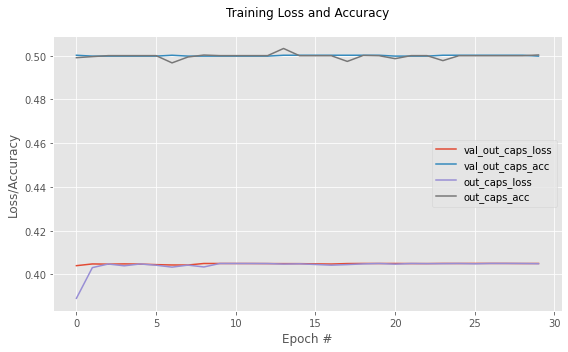


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.405    | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.404    | 0.500    | 0.500     | 1.000    | 0.667   

-------------------------------
Testing with filter sizes 32/64
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 52s 2ms/step - loss: 0.2121 - out_caps_loss: 0.2120 - out_recon_loss: 0.0751 - out_caps_acc: 0.5928 - out_recon_acc: 0.4280 - val_loss: 0.1844 - val_out_caps_loss: 0.1844 - val_out_recon_loss: 0.0358 - val_out_caps_acc: 0.6727 - val_out_recon_acc: 0.5370
Epoch 2/30
22321/22321 [==============================] - 31s 1ms/step - loss: 0.1900 - out_caps_loss: 0.

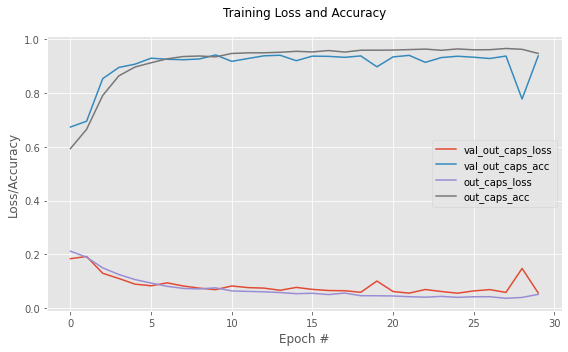


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.057    | 0.936    | 0.934     | 0.938    | 0.936   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.056    | 0.936    | 0.950     | 0.919    | 0.935   

-------------------------------
Testing with filter sizes 64/64
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 52s 2ms/step - loss: 0.4013 - out_caps_loss: 0.4013 - out_recon_loss: 0.0712 - out_caps_acc: 0.5024 - out_recon_acc: 0.4352 - val_loss: 0.3927 - val_out_caps_loss: 0.3926 - val_out_recon_loss: 0.0357 - val_out_caps_acc: 0.5002 - val_out_recon_acc: 0.5347
Epoch 2/30
22321/22321 [==============================] - 31s 1ms/step - loss: 0.4034 - out_caps_loss: 0.

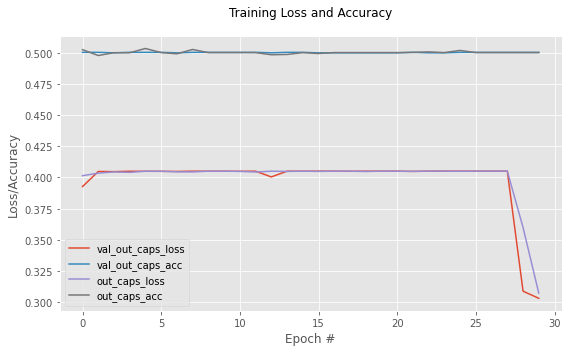


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.305    | 0.500    | 0.500     | 1.000    | 0.667   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.305    | 0.500    | 0.500     | 1.000    | 0.667   



In [0]:
flist=[[4,8],
       [8,16],
       [16,32],
       [24,48],
       [32,64],
       [64,64]]

for f_size in flist:
      print("-------------------------------")
      print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
      print("-------------------------------")
      (model, scores), hist = CapsTest([9,9], 
                                      frac=100, 
                                      bs=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      plot = True, 
                                      f_sizes=f_size,
                                      es=False,
                                      pltFile="6c_CapsnetModel_9.9_frac100_f{}.{}.png".format(f_size[0],f_size[1]),
                                      bestFile="test_{}.{}.h5".format(f_size[0],f_size[1]))
      showScores(scores)

      print("")
      print("Best model (min val loss) scores")
      try:
          model.load_weights("test_{}.{}.h5".format(f_size[0],f_size[1]))
          showModelScores(model, test_X, test_Y)
      except:
          pass
      print("") 

-------------------------------
Testing with filter sizes 128/128
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 74s 3ms/step - loss: 0.2028 - out_caps_loss: 0.2028 - out_recon_loss: 0.0758 - out_caps_acc: 0.6346 - out_recon_acc: 0.4155 - val_loss: 0.1762 - val_out_caps_loss: 0.1762 - val_out_recon_loss: 0.0358 - val_out_caps_acc: 0.6816 - val_out_recon_acc: 0.5324
Epoch 2/30
22321/22321 [==============================] - 52s 2ms/step - loss: 0.1644 - out_caps_loss: 0.1644 - out_recon_loss: 0.0346 - out_caps_acc: 0.7281 - out_recon_acc: 0.5237 - val_loss: 0.1237 - val_out_caps_loss: 0.1237 - val_out_recon_loss: 0.0350 - val_out_caps_acc: 0.8609 - val_out_recon_acc: 0.5122
Epoch 3/30
22321/22321 [==============================] - 52s 2ms/step - loss: 0.1034 - out_caps_loss: 0.1034 - out_recon_loss: 0.0344 - out_caps_acc: 0.8871 - out_recon_acc: 0.5132 - val_loss: 0.0845 - val_out_caps_loss: 0.084

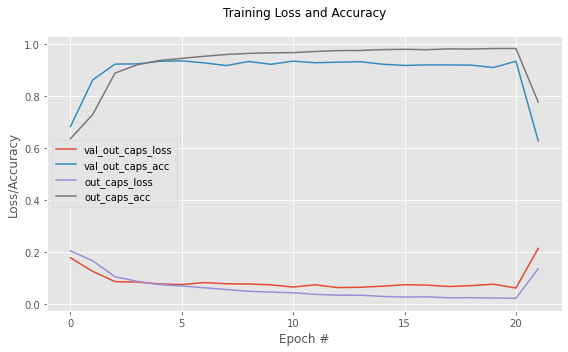


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.203    | 0.644    | 0.658     | 0.602    | 0.629   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.058    | 0.936    | 0.945     | 0.925    | 0.935   

-------------------------------
Testing with filter sizes 256/256
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 121s 5ms/step - loss: 0.4054 - out_caps_loss: 0.4054 - out_recon_loss: 0.0737 - out_caps_acc: 0.4993 - out_recon_acc: 0.4215 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0354 - val_out_caps_acc: 0.4994 - val_out_recon_acc: 0.5346
Epoch 2/30
22321/22321 [==============================] - 99s 4ms/step - loss: 0.4050 - out_caps_loss:

In [0]:
flist=[[128,128],
       [256,256]]

for f_size in flist:
      print("-------------------------------")
      print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
      print("-------------------------------")
      (model, scores), hist = CapsTest([5,9], 
                                      frac=100, 
                                      bs=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      plot = True, 
                                      f_sizes=f_size,
                                      es=True,
                                      pltFile="6c_CapsnetModel_5.9_frac100_f{}.{}.png".format(f_size[0],f_size[1]),
                                      bestFile="test_{}.{}.h5".format(f_size[0],f_size[1]))
      showScores(scores)

      print("")
      print("Best model (min val loss) scores")
      try:
          model.load_weights("test_{}.{}.h5".format(f_size[0],f_size[1]))
          showModelScores(model, test_X, test_Y)
      except:
          pass
      print("") 

##11 Save models and images

In [0]:
%%bash
cp -f ./*.h5 "$GPATH/Models"
cp -f ./*.json "$GPATH/Models"
cp -f ./*.png "$GPATH/Images"

sample_data


cp: cannot stat './*.h5': No such file or directory
cp: cannot stat './*.json': No such file or directory
cp: cannot stat './*.png': No such file or directory
